In [21]:
# Instalar dependências, se necessário


In [22]:

# Importações
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os


In [23]:
# Configurações
DATASET_PATH = "/home/guilherme/Documentos/Dataset's/WaterMeters"

DATA_CSV_PATH = os.path.join(DATASET_PATH, 'data.csv')
IMAGES_FOLDER = os.path.join(DATASET_PATH, "images")
IMAGE_SIZE = (512, 512)  # Tamanho padrão para redes neurais
BATCH_SIZE = 16
EPOCHS = 20

# Configurar seed para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:

# Carregar dados do CSV
df = pd.read_csv(DATA_CSV_PATH)

# Preparar listas para armazenar imagens e valores
images = []
values = []

# Iterar sobre registros do DataFrame
for index, row in df.iterrows():
    image_path = os.path.join(IMAGES_FOLDER, row['photo_name'])
    
    if not os.path.exists(image_path):
        print(f"Aviso: Imagem {image_path} não encontrada.")
        continue
    
    img = cv2.imread(image_path)
    if img is None:
        print(f"Erro ao carregar imagem: {image_path}")
        continue
    
    # Processar a imagem
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMAGE_SIZE)
    img = img.astype('float32') / 255.0  # Normalizar para [0, 1]
    
    images.append(img)
    values.append(row['value'])

# Converter listas para arrays
X = np.array(images)
y = np.array(values)

# Verificar formatos
print("Formato de X:", X.shape)  # Deve ser (n_amostras, 224, 224, 3)
print("Formato de y:", y.shape)  # Deve ser (n_amostras,)
print("Imput Shape", X.shape[1:])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar valores alvo
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()


In [ ]:
import os
import numpy as np
import tensorflow as tf
from keras.models import load_model
from keras import callbacks
from keras import models, layers, optimizers

# Optional: Disable GPU if not needed
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Check TensorFlow GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Criar o modelo CNN atualizado
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X.shape[1:])),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(1, activation='linear')  # Saída linear para regressão
])
# Otimizador SGD como alternativa ao Adam
sgd = optimizers.SGD(learning_rate=0.01, momentum=0.9)



# Compilar o modelo
model.compile(
    optimizer=sgd,  # Alterado para Adam
    loss='mean_squared_error',
    metrics=['mae']
)

# Resumo do modelo
model.summary()




Num GPUs Available:  0
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# Early stopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Número de épocas sem melhora
    restore_best_weights=True  # Restaurar os melhores pesos
)

# Treinamento do modelo
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,  # Aumentado para treinar por mais épocas
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stopping], 
    verbose=1
)

Epoch 1/20
25/25 [==============================] - 16s 632ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/20
25/25 [==============================] - 16s 635ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/20
25/25 [==============================] - 16s 654ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/20
25/25 [==============================] - 16s 628ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/20
25/25 [==============================] - 16s 627ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan


In [ ]:

# Avaliação no conjunto de teste
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

# Previsões no conjunto de teste
y_pred = model.predict(X_test)

# Cálculo do MAE com sklearn
mae = mean_absolute_error(y_test, y_pred)

print(f"Loss no conjunto de teste: {test_loss}")
print(f"MAE no conjunto de teste: {mae}")

# Plotar a curva de treino e validação
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

# Métrica MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Treinamento')
plt.plot(history.history['val_mae'], label='Validação')
plt.title('MAE durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

8/8 [==============================] - 1s 130ms/step


ValueError: Input contains NaN.

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


8/8 [==============================] - 1s 146ms/step
Loss no conjunto de teste: [8281057.5, 389.9378662109375]
Erro Absoluto Médio (MAE) no conjunto de teste: 389.93789073159707


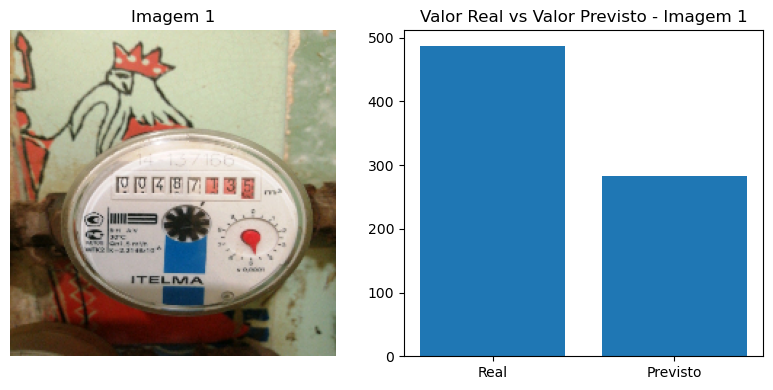

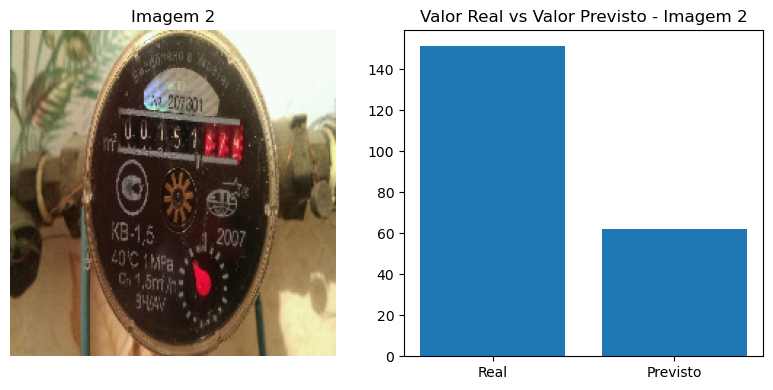

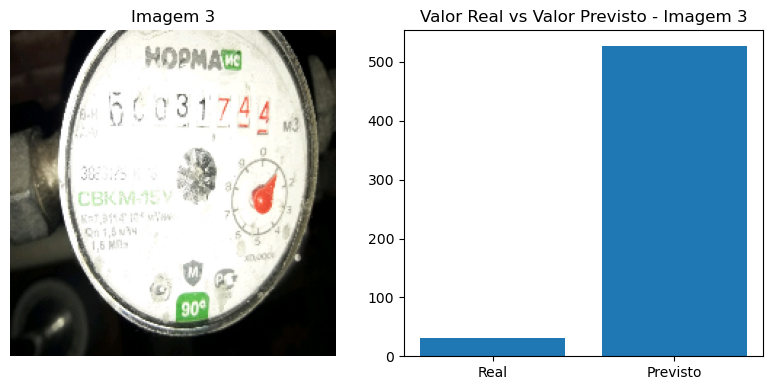

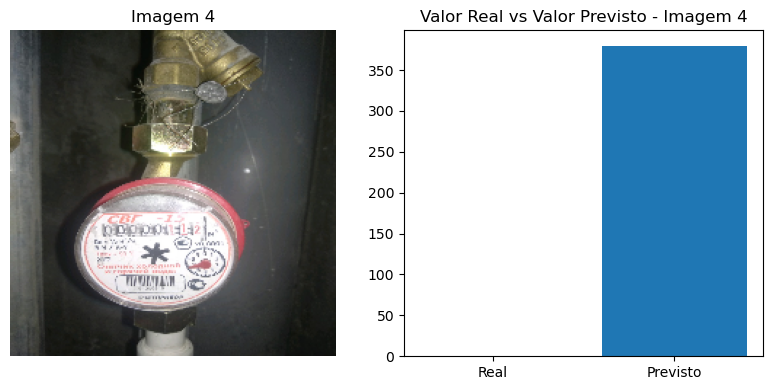

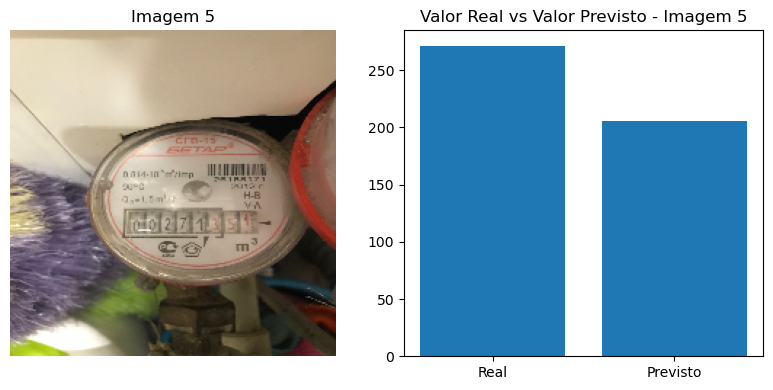

In [ ]:
    
# Avaliação no conjunto de teste
test_loss = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_test)

# Calcular o erro absoluto médio (MAE)
mae = mean_absolute_error(y_test, y_pred)

print(f"Loss no conjunto de teste: {test_loss}")
print(f"Erro Absoluto Médio (MAE) no conjunto de teste: {mae}")

# Mostrar o valor real, previsto e a imagem para a confirmação
for i in range(5):  # Exibir as primeiras 5 imagens para inspeção
    plt.figure(figsize=(8, 4))
    
    # Exibir a imagem
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[i])  # Certifique-se de que X_test[i] está no formato correto (por exemplo, RGB)
    plt.axis('off')  # Remover os eixos para melhor visualização
    plt.title(f"Imagem {i+1}")
    
    # Exibir os valores reais e previstos
    plt.subplot(1, 2, 2)
    plt.bar(['Real', 'Previsto'], [y_test[i], y_pred[i][0]])
    plt.title(f"Valor Real vs Valor Previsto - Imagem {i+1}")
    
    plt.tight_layout()
    plt.show()